In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt


In [4]:

# Set seed and device
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess data
df = pd.read_csv("data.csv")
df.drop('Sl. No.', axis=1, inplace=True)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=8, shuffle=False)


Using device: cuda


In [ ]:

# Define ANN
class ANN(nn.Module):
    def __init__(self, input_features, hidden_layers=2, neurons_per_layer=64, activation_function=nn.ReLU(), dropout_rate=0.2):
        super().__init__()
        layers = [nn.Linear(input_features, neurons_per_layer), activation_function,
                  nn.BatchNorm1d(neurons_per_layer), nn.Dropout(dropout_rate)]

        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(neurons_per_layer, neurons_per_layer), activation_function,
                       nn.BatchNorm1d(neurons_per_layer), nn.Dropout(dropout_rate)]

        layers.append(nn.Linear(neurons_per_layer, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [ ]:

# Random hyperparameter generation
def generate_individual():
    return {
        'learning_rate': random.uniform(1e-5, 1e-3),
        'epochs': random.randint(100, 300),  # Keep smaller for faster tuning
        'activation_function': random.choice([nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.SELU(), nn.LeakyReLU(), nn.ELU()]),
        'hidden_layers': random.randint(1, 10),
        'neurons_per_layer': random.randint(32, 256),
        'dropout_rate': random.uniform(0.2, 0.5),
        'optimizer': random.choice([optim.Adam, optim.SGD, optim.RMSprop, optim.Adadelta, optim.Adagrad, optim.Adamax])
    }
# Fitness function 
def fitness(params, model_class, train_loader, test_loader, device):
    
    model_params = {k: v for k, v in params.items() if k not in ['learning_rate', 'epochs', 'optimizer']}
    model = model_class(input_features=X_train.shape[1], **model_params)
    model.to(device)
    
    
    criterion = nn.MSELoss()
    optimizer = params['optimizer'](model.parameters(), lr=params['learning_rate'])

    # Training loop
    for epoch in range(params['epochs']):
        model.train()
        for X_batch, y_batch in train_loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation loop
    model.eval()
    with torch.no_grad():
        total_loss = sum(F.mse_loss(model(X), y).item() for X, y in test_loader)
    
    return total_loss / len(test_loader)


In [ ]:

def jaya_algorithm(pop_size=10, generations=100, model_class=ANN):
    population = [generate_individual() for _ in range(pop_size)]
    best_solution = None
    best_fitness = float('inf')
    best_model_path = "best_model.pt"

    for gen in range(generations):
        fitness_vals = [fitness(ind, model_class, train_loader, test_loader, device) for ind in population]
        best_idx = np.argmin(fitness_vals)
        worst_idx = np.argmax(fitness_vals)

        best_ind, worst_ind = population[best_idx], population[worst_idx]
        current_best_fitness = fitness_vals[best_idx]

        # Save model if it's better than the previous best
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_solution = best_ind

            print(f"✅ Saving new best model at generation {gen+1} with MSE: {best_fitness:.4f}")
            model_params = {k: v for k, v in best_solution.items() if k not in ['learning_rate', 'epochs', 'optimizer']}
            model = model_class(input_features=X_train.shape[1], **model_params).to(device)
            criterion = nn.MSELoss()
            optimizer = best_solution['optimizer'](model.parameters(), lr=best_solution['learning_rate'])

            for epoch in range(best_solution['epochs']):
                model.train()
                for X_batch, y_batch in train_loader:
                    preds = model(X_batch)
                    loss = criterion(preds, y_batch)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            torch.save(model.state_dict(), best_model_path)

        new_population = []
        for ind in population:
            candidate = {}
            for param in ind:
                x = ind[param]
                best_x = best_ind[param]
                worst_x = worst_ind[param]
                r1, r2 = random.random(), random.random()

                if isinstance(x, (int, float)):
                    new_x = x + r1 * (best_x - abs(x)) - r2 * (worst_x - abs(x))
                    if param == 'learning_rate':
                        new_x = max(min(new_x, 1e-3), 1e-5)
                    elif param == 'epochs':
                        new_x = int(max(min(new_x, 1000), 100))
                    elif param == 'neurons_per_layer':
                        new_x = int(max(min(new_x, 128), 32))
                    elif param == 'dropout_rate':
                        new_x = max(min(new_x, 0.5), 0.2)
                    else:
                        new_x = int(max(min(new_x, 4), 1))
                    candidate[param] = new_x
                else:
                    candidate[param] = random.choice([x, best_x])

            candidate_fitness = fitness(candidate, model_class, train_loader, test_loader, device)
            new_population.append(candidate if candidate_fitness < fitness_vals[population.index(ind)] else ind)

        population = new_population
        print(f"Generation {gen+1}: Best Test MSE: {best_fitness:.4f}")

    print("🔍 Final Best Hyperparameters:", best_solution)
    return best_solution


✅ Saving new best model at generation 1 with MSE: 1186.7039
Generation 1: Best Test MSE: 1186.7039
Generation 2: Best Test MSE: 1186.7039
✅ Saving new best model at generation 3 with MSE: 900.3917
Generation 3: Best Test MSE: 900.3917
✅ Saving new best model at generation 4 with MSE: 773.4282
Generation 4: Best Test MSE: 773.4282
✅ Saving new best model at generation 5 with MSE: 603.8747
Generation 5: Best Test MSE: 603.8747
Generation 6: Best Test MSE: 603.8747
✅ Saving new best model at generation 7 with MSE: 524.2373
Generation 7: Best Test MSE: 524.2373
Generation 8: Best Test MSE: 524.2373
✅ Saving new best model at generation 9 with MSE: 510.4676
Generation 9: Best Test MSE: 510.4676
Generation 10: Best Test MSE: 510.4676
Generation 11: Best Test MSE: 510.4676
✅ Saving new best model at generation 12 with MSE: 502.5778
Generation 12: Best Test MSE: 502.5778
✅ Saving new best model at generation 13 with MSE: 482.6057
Generation 13: Best Test MSE: 482.6057
✅ Saving new best model a

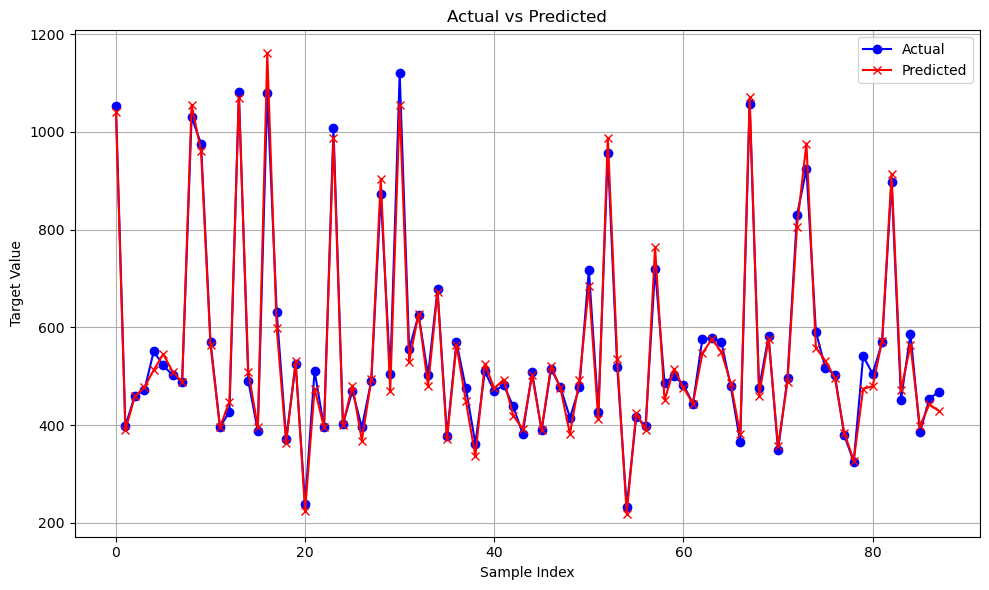

In [ ]:


best_hyperparams = jaya_algorithm()


final_model = ANN(input_features=X_train.shape[1], **{k: v for k, v in best_hyperparams.items() if k not in ['learning_rate', 'epochs', 'optimizer']})
final_model.to(device)
criterion = nn.MSELoss()
optimizer = best_hyperparams['optimizer'](final_model.parameters(), lr=best_hyperparams['learning_rate'])

for epoch in range(best_hyperparams['epochs']):
    final_model.train()
    for X_batch, y_batch in train_loader:
        preds = final_model(X_batch)
        loss = criterion(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def evaluate(model, loader, name='Test'):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            loss = F.mse_loss(preds, y_batch)
            total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    print(f"{name} MSE: {avg_loss:.4f}, RMSE: {avg_loss**0.5:.4f}")
    return avg_loss

evaluate(final_model, train_loader, name='Train')
evaluate(final_model, test_loader, name='Test')


final_model.eval()
with torch.no_grad():
    preds = final_model(X_test_tensor).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual', color='blue', marker='o')
plt.plot(preds, label='Predicted', color='red', marker='x')
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the ANN model
class ANN(nn.Module):
    def __init__(self, input_features):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_features, 126),
            nn.ReLU(),
            nn.BatchNorm1d(126),
            nn.Dropout(0.2),
            nn.Linear(126, 1)
        )

    def forward(self, x):
        return self.model(x)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
input_features = X_train.shape[1]  
final_model = ANN(input_features=input_features)

# Load the model weights
final_model.load_state_dict(torch.load(r"C:\Users\ipsit\Downloads\fatigue\best_model.pt", map_location=device))
final_model.to(device)
final_model.eval()

# Make predictions
with torch.no_grad():
    y_pred = final_model(X_test_tensor).cpu().numpy()  
    y_true = y_test_tensor.cpu().numpy() 

# Calculate evaluation metrics
print("Test MSE:", mean_squared_error(y_true, y_pred))
print("Test MAE:", mean_absolute_error(y_true, y_pred))
print("Test R2 Score:", r2_score(y_true, y_pred))


Test MSE: 450.88425
Test MAE: 16.332184
Test R2 Score: 0.9890944748500766
